In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
import pickle
import matplotlib.pyplot as plt

with open('Data/LENSEGUA.pkl', 'rb') as f:
    data = pickle.load(f)

print(data.shape)
data.head()

(768, 2)


,SENTENCE,COORDINATES
0,Tu,"[[-23, 379, 4, 354, 33, 333, 64, 328, 87, 330,..."
1,Hoy,"[[], [-127, 566, -98, 535, -54, 526, -16, 536,..."
2,Que,"[[], [270, 714, 242, 726, 232, 751, 227, 776, ..."
3,Universidad,"[[], [-93, 484, -51, 483, -17, 503, 2, 525, 12..."
4,Como,"[[], [-117, 655, -84, 668, -65, 693, -52, 713,..."


In [2]:
print(data["SENTENCE"].value_counts())

SENTENCE
Tu                  12
Hoy                 12
Que_INV_            12
Universidad_INV_    12
Como_INV_           12
                    ..
Necesito            12
Yo                  12
Cuanto              12
Donde               12
Policia_INV_        12
Name: count, Length: 64, dtype: int64


Classes:  64
Percentage of data deleted:  12.593835555948072 %


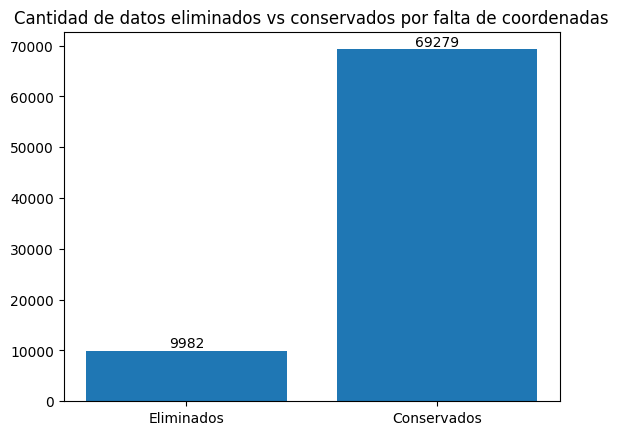

In [3]:
newData = pd.DataFrame(columns=["LABEL", "COORDS"])
      
numClasses = len(data["SENTENCE"].unique())
classes = {}
dictClasses = []

for i in range(numClasses):
    classes[data["SENTENCE"].unique()[i]] = i
    dictClasses.append(data["SENTENCE"].unique()[i])
    
deleted = 0
for _, row in data.iterrows():
    for frame in row["COORDINATES"]:
        if frame is None or len(frame) != 84:
            deleted += 1
            continue
        
        newRow = pd.DataFrame(columns=["LABEL", "COORDS"])
        newRow["LABEL"] = [classes[row["SENTENCE"]]]
        newRow["COORDS"] = [frame]

        newData = pd.concat([newData, newRow], ignore_index=True)

data = newData
data.head()

plt.bar(["Eliminados", "Conservados"], [deleted, data.shape[0]])
plt.text(0, deleted, str(deleted), ha='center', va='bottom')
plt.text(1, data.shape[0], str(data.shape[0]), ha='center', va='bottom')
plt.title("Cantidad de datos eliminados vs conservados por falta de coordenadas")

print("Classes: ", len(classes))
print("Percentage of data deleted: ", (deleted/(deleted + data.shape[0])) * 100, "%")


In [4]:
def augmentData(data, copies = 2, noise = 5):
    augmentedData = pd.DataFrame(columns=data.columns)
    for _ in range(copies):
        for _, row in data.iterrows():
            newRow = row.copy()

            for value in newRow["COORDS"]:
                value += np.random.randint(-noise, noise)

            augmentedData = pd.concat([augmentedData, newRow.to_frame().T])

    return augmentedData

print("Data shape before augmentation: ", data.shape)
data = augmentData(data, 3, 2)
# data = augmentData(data, 10, 4)
print("Data shape after augmentation: ", data.shape)
data.head()

Data shape before augmentation:  (69279, 2)
Data shape after augmentation:  (207837, 2)


,LABEL,COORDS
0,0,"[-23, 379, 4, 354, 33, 333, 64, 328, 87, 330, ..."
1,0,"[-26, 382, 11, 360, 41, 340, 67, 330, 89, 328,..."
2,0,"[-26, 382, 11, 358, 41, 339, 67, 330, 90, 329,..."
3,0,"[-25, 381, 11, 358, 40, 339, 67, 330, 89, 328,..."
4,0,"[-25, 381, 13, 359, 42, 340, 68, 330, 89, 328,..."


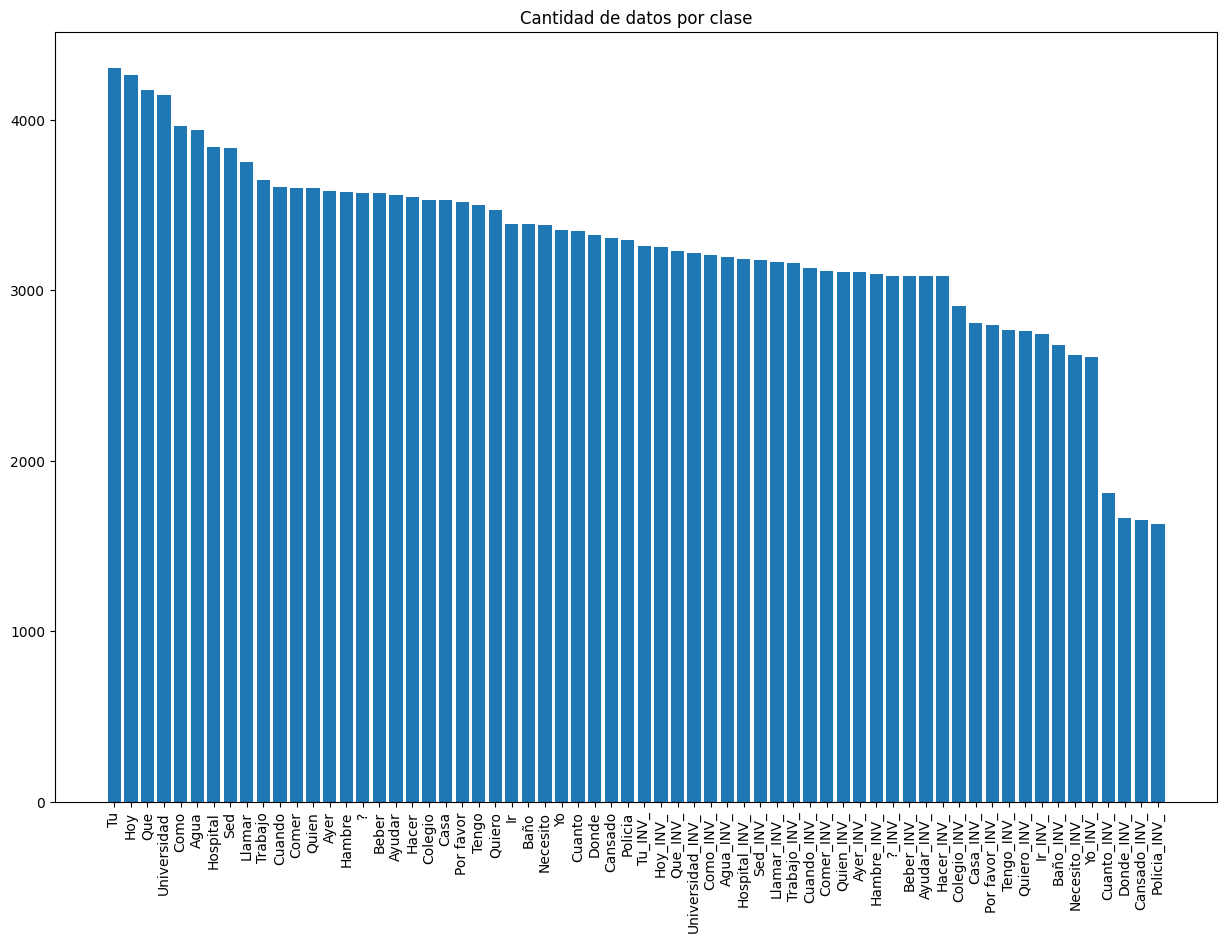

Average:  31.450035364251793
Standard Deviation:  18.49154303676055


In [9]:
plt.figure(figsize=(15,10))
plt.bar(dictClasses, data["LABEL"].value_counts())
plt.title("Cantidad de datos por clase")
plt.xticks(rotation=90)
plt.show()

average = data["LABEL"].mean()
std_dev = data["LABEL"].std()

print("Average: ", average)
print("Standard Deviation: ", std_dev)

In [52]:
minPoint = 0
maxPoint = 0

for row in data["COORDS"]:
    for value in row:
        if value < minPoint: minPoint = value
        if value > maxPoint: maxPoint = value

print("Min point: ", minPoint)
print("Max point: ", maxPoint)

def customScaler(data, minPoint, maxPoint):  
    newData = pd.DataFrame(columns=data.columns)
    for _, row in data.iterrows():
        coords = row["COORDS"]
        newCoords = []
        for coord in coords:
            if coord < 0: newCoords.append(coord / abs(minPoint))
            elif coord > 0: newCoords.append(coord / maxPoint)
            else: newCoords.append(0)

        newRow = row.copy()
        newRow["COORDS"] = newCoords
        newData = pd.concat([newData, newRow.to_frame().T])
      
    return newData

data = customScaler(data, minPoint, maxPoint)
print("Data shape after scaling: ", data.shape)
data.head()

Min point:  -555
Max point:  1125
Data shape after scaling:  (207837, 2)


,LABEL,COORDS
0,0,"[-0.04144144144144144, 0.3368888888888889, 0.0..."
1,0,"[-0.04684684684684685, 0.33955555555555555, 0...."
2,0,"[-0.04684684684684685, 0.33955555555555555, 0...."
3,0,"[-0.04504504504504504, 0.33866666666666667, 0...."
4,0,"[-0.04504504504504504, 0.33866666666666667, 0...."


In [53]:
labels = to_categorical(data["LABEL"], numClasses)

dataset = data
data = np.array(data["COORDS"].values.tolist())
data = data.reshape(data.shape[0], data.shape[1])

print("Labels shape: ", labels.shape)
print("Data shape: ", data.shape)
print(data[0])

Labels shape:  (207837, 64)
Data shape:  (207837, 84)
[-0.04144144  0.33688889  0.00355556  0.31466667  0.02933333  0.296
  0.05688889  0.29155556  0.07733333  0.29333333  0.01688889  0.26666667
  0.05866667  0.27466667  0.072       0.29244444  0.07288889  0.30488889
  0.01333333  0.27555556  0.05866667  0.29333333  0.05688889  0.31288889
  0.04711111  0.31733333  0.01244444  0.28977778  0.05511111  0.30577778
  0.05155556  0.32266667  0.03911111  0.32622222  0.01244444  0.30577778
  0.04622222  0.31822222  0.04355556  0.32888889  0.03377778  0.33066667
  0.23644444  0.56977778  0.21333333  0.584       0.208       0.61155556
  0.208       0.63822222  0.20355556  0.656       0.24355556  0.62755556
  0.24        0.66488889  0.232       0.68088889  0.22577778  0.69155556
  0.25688889  0.62755556  0.25155556  0.66577778  0.24        0.68
  0.23022222  0.68977778  0.26311111  0.62577778  0.25955556  0.656
  0.24888889  0.66666667  0.24        0.672       0.264       0.62222222
  0.26222222 

In [54]:
threshold = 20
confidence = 0.9

with open('Data/modelParams.pkl', 'wb') as f:
    pickle.dump(numClasses, f)
    pickle.dump(dictClasses, f)
    pickle.dump(minPoint, f)
    pickle.dump(maxPoint, f)
    pickle.dump(confidence, f)
    pickle.dump(threshold, f)

with open('Data/processedData.pkl', 'wb') as f:
    pickle.dump(data, f)
    pickle.dump(labels, f)

with open('Data/trainingData.pkl', 'wb') as f:
    pickle.dump(dataset, f)
    pickle.dump(classes, f)